In [ ]:
#!pip install pycaret

In [49]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

#from pycaret.regression import setup, compare_models

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score

import optuna

In [ ]:
#catboost
#br
#ridge
#lightgpm
#gpr
#xgboost

In [50]:
train0 = pd.read_csv('/kaggle/input/diamond-price-prediction/diamond-price-prediction/train.csv')
test0 = pd.read_csv('/kaggle/input/diamond-price-prediction/diamond-price-prediction/test.csv')

In [ ]:
train0

In [ ]:
test0

In [ ]:
train0.info()

In [ ]:
test0.info()

In [ ]:
train0.isna().sum()

In [ ]:
test0.isna().sum()

# **Combine train and test sets**

In [51]:
target = train0['price']
test_ids = test0['Id']
train1 = train0.drop(['Id', 'price'], axis=1)
test1 = test0.drop('Id', axis=1)

data1 = pd.concat([train1, test1], axis=0).reset_index(drop=True)
data1

,carat,cut,color,clarity,depth,table,x,y,z
0,1.06,Ideal,I,SI2,61.8,57.0,6.57,6.60,4.07
1,1.51,Premium,G,VVS2,60.9,58.0,7.38,7.42,4.51
2,0.32,Ideal,F,VS2,61.3,56.0,4.43,4.41,2.71
3,0.53,Ideal,G,VS2,61.2,56.0,5.19,5.22,3.19
4,0.70,Premium,H,VVS2,61.0,57.0,5.76,5.72,3.50
...,...,...,...,...,...,...,...,...,...
53935,0.57,Ideal,H,VS1,60.9,56.0,5.34,5.36,3.26
53936,1.05,Ideal,G,VS2,60.8,57.0,6.65,6.58,4.02
53937,0.71,Ideal,E,VVS1,62.3,55.0,5.68,5.72,3.55
53938,1.11,Premium,E,SI2,61.0,60.0,6.68,6.66,4.07


In [ ]:
target

# **Cleaning**

**Numeric Missing Values**

In [ ]:
data1.select_dtypes(np.number).isna().sum()

In [53]:
data1['cut'].replace(('Fair','Good','Very Good','Premium','Ideal'),(1,2,3,4,5), inplace = True)
data1['color'].replace(('D','E','F','G','H','I','J'),(7,6,5,4,3,2,1), inplace = True)
data1['clarity'].replace(('I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF'),(1,2,3,4,5,6,7,8),inplace = True)

# Feature Transformations

In [54]:
skew_df = pd.DataFrame(data1.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data1[feature]))

skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,carat,1.116615,1.116615,True
1,cut,-0.717161,0.717161,True
2,color,-0.189361,0.189361,False
3,clarity,0.551422,0.551422,True
4,depth,-0.082292,0.082292,False
5,table,0.796874,0.796874,True
6,x,0.378666,0.378666,False
7,y,2.434099,2.434099,True
8,z,1.522380,1.522380,True


In [55]:
data1[skew_df.query("Skewed == True")['Feature'].values].describe()

,carat,cut,clarity,table,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,3.904097,4.051020,57.457184,5.734526,3.538734
std,0.474011,1.116600,1.647136,2.234491,1.142135,0.705699
min,0.200000,1.000000,1.000000,43.000000,0.000000,0.000000
25%,0.400000,3.000000,3.000000,56.000000,4.720000,2.910000
50%,0.700000,4.000000,4.000000,57.000000,5.710000,3.530000
75%,1.040000,5.000000,5.000000,59.000000,6.540000,4.040000
max,5.010000,5.000000,8.000000,95.000000,58.900000,31.800000


In [57]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    data1[column] = np.log1p(data1[column])

In [58]:
skew_df = pd.DataFrame(data1.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data1[feature]))

skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,carat,0.580638,0.580638,True
1,cut,-1.290527,1.290527,True
2,color,-0.189361,0.189361,False
3,clarity,-0.101383,0.101383,False
4,depth,-0.082292,0.082292,False
5,table,0.602215,0.602215,True
6,x,0.378666,0.378666,False
7,y,0.006599,0.006599,False
8,z,-0.145420,0.145420,False


In [20]:
data2 = data1.copy()

# **Encode**

In [21]:
data2 = pd.get_dummies(data2)

In [22]:
data3 = data2.copy()

# Scaling

In [23]:
scaler = StandardScaler()
scaler.fit(data3)

data3 = pd.DataFrame(scaler.transform(data3), index=data3.index, columns=data3.columns)

In [24]:
data3

,carat,cut,color,clarity,depth,table,x,y,z
0,0.683607,0.877724,-1.414272,-1.421085,0.035317,-0.188918,0.747798,0.814925,0.796881
1,1.490531,0.191703,-0.238555,1.153427,-0.592908,0.263816,1.469884,1.435277,1.338407
2,-1.134121,0.877724,0.349304,0.131057,-0.313697,-0.649525,-1.159935,-1.242991,-1.235271
3,-0.531161,0.877724,-0.238555,0.131057,-0.383500,-0.649525,-0.482422,-0.398264,-0.443588
4,-0.100858,0.191703,-0.826413,1.153427,-0.523105,-0.188918,0.025712,0.069859,0.020850
...,...,...,...,...,...,...,...,...,...
53935,-0.425759,0.877724,-0.826413,0.685041,-0.592908,-0.649525,-0.348703,-0.263500,-0.335780
53936,0.663733,0.877724,-0.238555,0.131057,-0.662711,-0.188918,0.819115,0.798971,0.732392
53937,-0.076904,0.877724,0.937163,1.559162,0.384331,-1.118285,-0.045605,0.069859,0.092750
53938,0.781552,0.191703,0.937163,-1.421085,-0.523105,1.146706,0.845859,0.862536,0.796881


In [25]:
data4 = data3.copy()

# Target Transformation

In [26]:
target

0         4270
1        15164
2          828
3         1577
4         2596
         ...  
43147     1760
43148     3016
43149      990
43150      734
43151      743
Name: price, Length: 43152, dtype: int64

<AxesSubplot: >

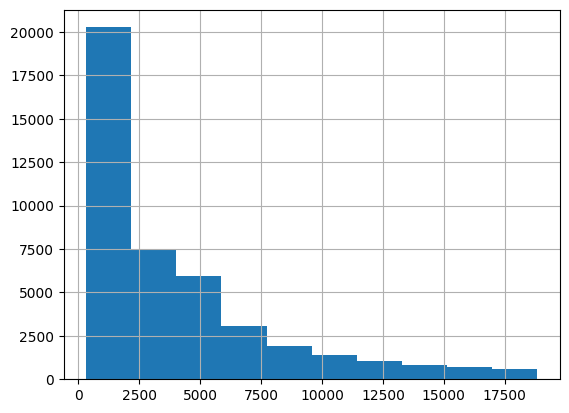

In [27]:
target.hist()

/tmp/ipykernel_34/2409864084.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target, kde=True, fit=scipy.stats.norm)
/tmp/ipykernel_34/2409864084.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(target), kde=True, fit=scipy.stats.norm)


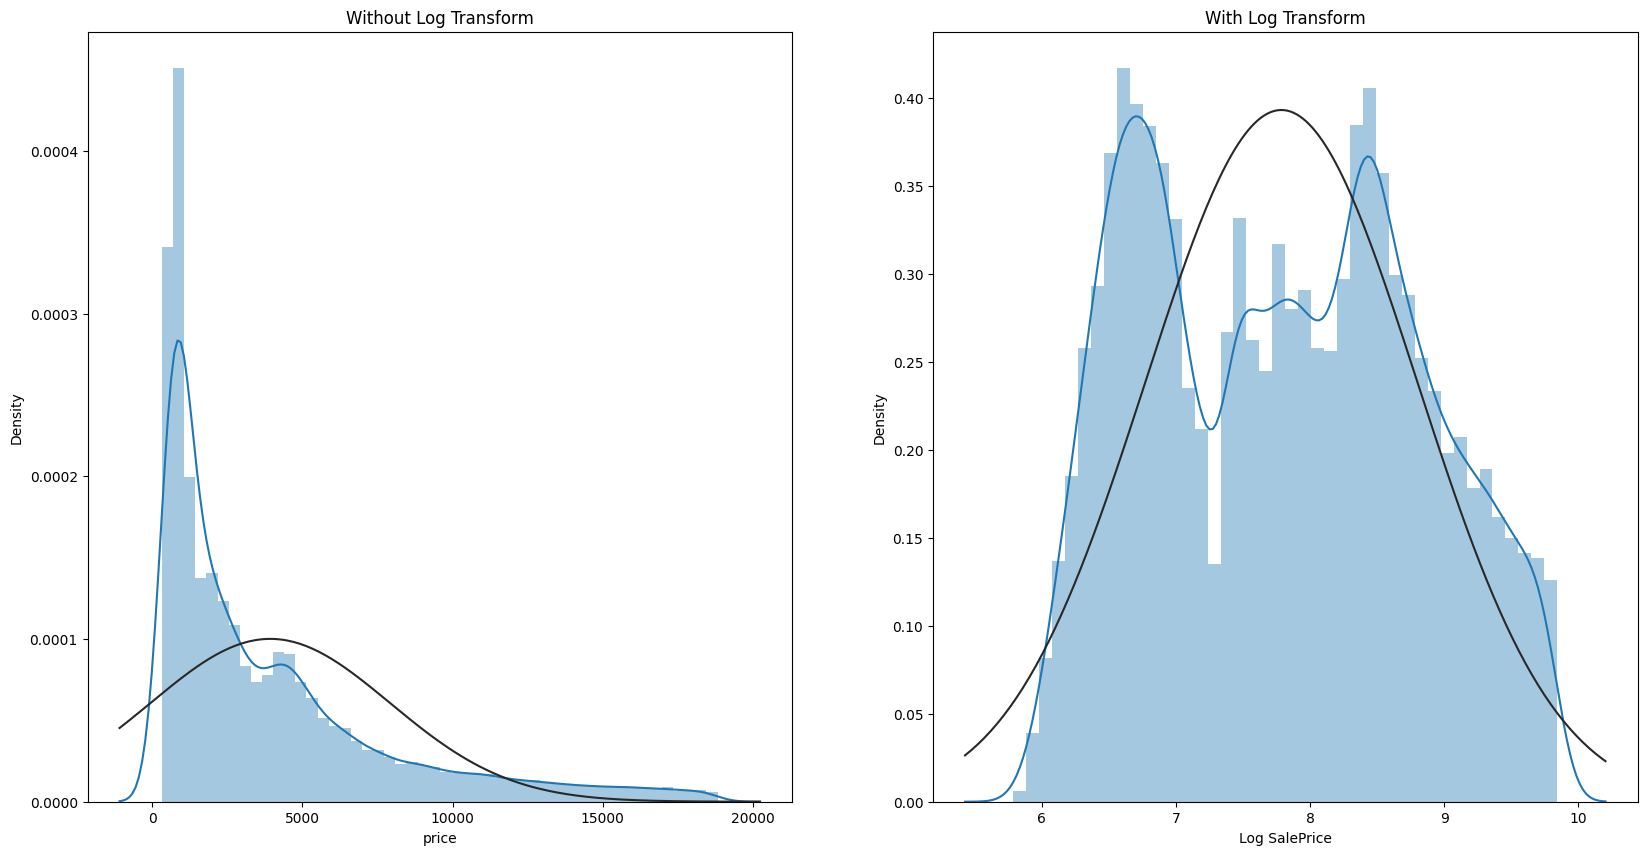

In [28]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.distplot(target, kde=True, fit=scipy.stats.norm)
plt.title("Without Log Transform")

plt.subplot(1, 2, 2)
sns.distplot(np.log(target), kde=True, fit=scipy.stats.norm)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()

In [29]:
log_target = np.log(target)

In [30]:
np.exp(log_target)

0         4270.0
1        15164.0
2          828.0
3         1577.0
4         2596.0
          ...   
43147     1760.0
43148     3016.0
43149      990.0
43150      734.0
43151      743.0
Name: price, Length: 43152, dtype: float64

# Split Data

In [ ]:
train_final = data4.loc[:train0.index.max(), :].copy()
test_final = data4.loc[train0.index.max() + 1:, :].reset_index(drop=True).copy()

In [ ]:
train_final

In [ ]:
test_final

# Model Selection

In [ ]:
#setup(data=pd.concat([train_final, log_target], axis=1), target='price')

In [ ]:
#compare_models()

# Bagging Ensemble

In [ ]:
models = {
    "catboost": CatBoostRegressor(verbose=0),
    "xgboost" : XGBRegressor(),
    "rf" : RandomForestRegressor(),
}

In [37]:
for name, model in models.items():
    model.fit(train_final, log_target)
    print(name + " trained.")

catboost trained.
xgboost trained.
rf trained.


# Evaluate

In [ ]:
results = {}

kf = KFold(n_splits=10)

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, train_final, log_target, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = result

In [ ]:
results

In [ ]:
for name, result in results.items():
    print("----------\n" + name)
    print(np.mean(result))
    print(np.std(result))

# Combine Predictions


In [ ]:
final_predictions = (
    0.5 * np.exp(models['catboost'].predict(test_final)) +
    0.2 * np.exp(models['xgboost'].predict(test_final)) +
    0.3 * np.exp(models['rf'].predict(test_final))
)

In [ ]:
final_predictions

In [ ]:
plt.figure(figsize=(16,10))
for name, model in models.items():
    sns.displot(results[name],bins=10, kde=True)
plt.show()    

# Make Submission


In [ ]:
submission = pd.concat([test_ids, pd.Series(final_predictions, name='price')], axis=1 )
submission

In [ ]:
submission.to_csv('./submission.csv', index=False, header=True)

In [ ]:
#catboost
#br
#ridge
#lightgpm
#gpr
#xgboost